In [62]:
# 1 patch with its top tokens
# Image with patch token overlay. Use top 1 token with threshold

# Model structure with lora
# Table of % of trainable params, highlight the one we chose

# Our dataset example (image + text)
# 3x Input image and text, and output for the original model and fine-tuned model

# Load model

In [2]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F

from share4v.model.builder import load_pretrained_model
from share4v.mm_utils import (
    process_images,
    tokenizer_image_token,
)

from share4v.constants import (
    DEFAULT_IMAGE_TOKEN,
    DEFAULT_IM_START_TOKEN,
    DEFAULT_IM_END_TOKEN,
    IMAGE_TOKEN_INDEX,
)

# Model configuration parameters
model_path = "Lin-Chen/ShareGPT4V-7B"  # HuggingFace repository path
model_name = "share4v-7b"               # Model identifier

# Load the pretrained model and its components
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path, None, model_name, False, False
)

share4v-7b
{'device_map': 'auto', 'torch_dtype': torch.float32}






/home/jupyter/.cache/pypoetry/virtualenvs/share4v-KfdsAbnj-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [01:03<00:00, 31.55s/it]


Load vision tower from Lin-Chen/ShareGPT4V-7B_Pretrained_vit-large336-l12


In [3]:
model=model.eval()

# Image tokens

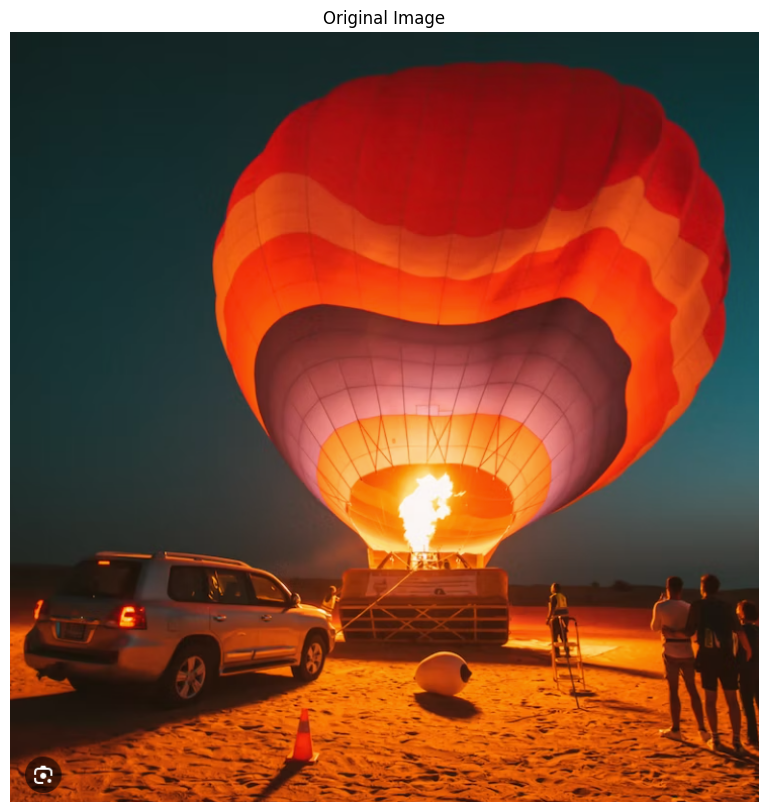

In [10]:
image_path = "../examples/photo.png"
image = Image.open(image_path).convert("RGB")

# Display the original image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.title("Original Image")
plt.show()

In [11]:
images = [image]
images_tensor = process_images(images, image_processor, model.config)
images_tensor = images_tensor.to(model.device, dtype=torch.float32)

In [12]:
# Get the token embeddings from the model
token_embeddings = model.model.embed_tokens.weight

# Get model vocab
vocabulary = tokenizer.get_vocab()

In [13]:
import english_words

english_words_set = english_words.get_english_words_set(["web2"], lower=True)

def is_word(text):
    if text.startswith("▁") and len(text) > 1:
        text = text[1:]
    return text.isdigit() or (text in english_words_set)

token_whitelist_mask = torch.BoolTensor(
    [is_word(v) for v in vocabulary],
)
sum(token_whitelist_mask)

tensor(7717)

In [14]:

# Create a function to find the closest token for each embedding
# This helps us understand what embedding vectors "mean" in token space
def find_closest_tokens(
    embeddings,
    token_embeddings,
    top_k=1,
    token_whitelist_mask=None,
):
    # If embedding is a single vector, add batch dimension
    if embeddings.dim() == 1:
        embeddings = embeddings.unsqueeze(0)
    if embeddings.dim() == 3:
        embeddings = embeddings[0]
    if token_embeddings.dim() == 3:
        token_embeddings = token_embeddings[0]

    with torch.no_grad():
        # Compute cosine similarity between embeddings and token embeddings
        normalized_embeddings = F.normalize(embeddings, p=2, dim=-1)
        normalized_token_embeddings = F.normalize(token_embeddings, p=2, dim=-1)
        similarities = torch.matmul(normalized_embeddings, normalized_token_embeddings.T)

    if token_whitelist_mask is not None:
        similarities[:, ~token_whitelist_mask] = 0

    # Get the top-k token indices with highest similarity
    if top_k == 1:
        closest_token_indices = similarities.argmax(dim=-1)
        return closest_token_indices
    else:
        top_k_values, top_k_indices = torch.topk(similarities, k=top_k, dim=-1)
        return top_k_indices, top_k_values

In [15]:
prompt = "Tell me a joke about programming."
stop_str = "<image>"
input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt')
embedded_tokens = model.model.embed_tokens(input_ids)

closest_token_indices = find_closest_tokens(
    embedded_tokens,
    token_embeddings,
)
closest_tokens = [tokenizer.decode(idx.item()).strip() for idx in closest_token_indices]
closest_tokens

['<s>', 'Tell', 'me', 'a', 'jo', 'ke', 'about', 'programming', '.']

## 1 patch

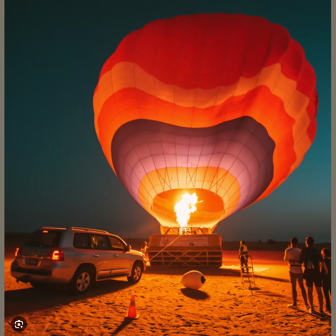

In [64]:
import torch
from torchvision.transforms.functional import to_pil_image

def reprocess(images_tensor):
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
    
    # Undo normalization
    image = images_tensor[0].cpu() * std + mean
    
    # Undo rescaling to [0, 255] and clamp
    image = (image * 255).clamp(0, 255).byte()

    return to_pil_image(image)
reprocess(images_tensor)

In [65]:
patch_size = 14
patch_in_line = 24

patch_number = 350

# First convert to x and y coordinates in patch space
x = patch_number % patch_in_line
y = patch_number // patch_in_line
print(f"Patch {patch_number} is at ({x}, {y}) in patch space")

# Convert to pixel space
x_pixel = x * patch_size
y_pixel = y * patch_size
print(f"Patch {patch_number} is at ({x_pixel}, {y_pixel}) in pixel space")

# Get the patch from the image tensor
patch = images_tensor[:, :, y_pixel:y_pixel + patch_size, x_pixel:x_pixel + patch_size]

Patch 350 is at (14, 14) in patch space
Patch 350 is at (196, 196) in pixel space


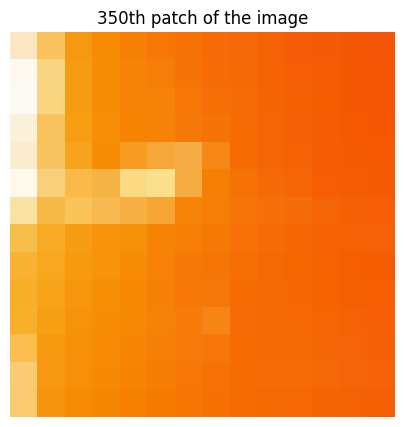

In [73]:
# patch_size = 14
# patch = images_tensor[:, :, :patch_size, :patch_size]
plt.figure(figsize=(5, 5))
plt.imshow(reprocess(patch))
plt.axis('off')
plt.title(f"{patch_number}th patch of the image")
plt.show()

In [69]:
image_features.shape

torch.Size([1, 576, 1024])

In [70]:
# Extract image features using the vision tower
with torch.no_grad():
    image_features = model.model.vision_tower(images_tensor)

# Map image features to text token space with the projector
with torch.no_grad():
    projected_features = model.model.mm_projector(image_features[:,patch_number,:])

In [71]:
top_k_indices, top_k_values = find_closest_tokens(
    projected_features,
    token_embeddings,
    top_k = 100
)
top_k_indices = top_k_indices[0]

for i in range(10):
    token = tokenizer.decode(top_k_indices[i].item()).strip()
    print(token, round(top_k_values[0][i].item(), 3))

fire 0.085
hot 0.083
lm 0.072
‒ 0.071
ill 0.07
smoke 0.069
RED 0.066
special 0.065
light 0.064
You 0.064


In [72]:
top_k_indices, top_k_values = find_closest_tokens(
    projected_features,
    token_embeddings,
    token_whitelist_mask=token_whitelist_mask,
    top_k = 100
)
top_k_indices = top_k_indices[0]

for i in range(10):
    token = tokenizer.decode(top_k_indices[i].item()).strip()
    print(token, round(top_k_values[0][i].item(), 3))

fire 0.085
hot 0.083
ill 0.07
smoke 0.069
special 0.065
light 0.064
so 0.064
you 0.063
5 0.06
equal 0.059


## Image patches

In [74]:
# Extract image features using the vision tower
with torch.no_grad():
    image_features = model.model.vision_tower(images_tensor)

# Map image features to text token space with the projector
with torch.no_grad():
    projected_features = model.model.mm_projector(image_features)

In [75]:
print(images_tensor.shape)
print(image_features.shape)
print(projected_features.shape)

torch.Size([1, 3, 336, 336])
torch.Size([1, 576, 1024])
torch.Size([1, 576, 4096])


In [76]:
(336/14) * (336/14) == 576

True

In [77]:
closest_token_indices = find_closest_tokens(
    projected_features,
    token_embeddings,
    token_whitelist_mask=token_whitelist_mask,
)

# Decode the tokens
closest_tokens = [tokenizer.decode(idx.item()).strip() for idx in closest_token_indices]

In [78]:
Counter(closest_tokens).most_common(10)

[('ass', 45),
 ('al', 32),
 ('red', 30),
 ('road', 28),
 ('sand', 22),
 ('light', 21),
 ('orange', 19),
 ('next', 18),
 ('you', 16),
 ('rep', 15)]

In [84]:
vision_config = model.model.vision_tower.vision_tower.config

def visualize_top_k_tokens_on_patches(image, token_embeddings, patch_embeddings, tokenizer, 
                                   patch_size=14, grid_size=None, top_k=3, sim_threshold=0.09):
    if grid_size is None:
        grid_size = int(np.sqrt(len(patch_embeddings)))
    
    # Get top-k tokens for each patch
    top_indices, top_probs = find_closest_tokens(
        patch_embeddings,
        token_embeddings,
        top_k=top_k,
        token_whitelist_mask=token_whitelist_mask,
    )
    # Decode the top tokens
    top_tokens = []
    for top_idxs, probs in zip(top_indices, top_probs):
        tokens = [tokenizer.decode(idx).strip() for idx in top_idxs]
        probs = probs.tolist()
        top_tokens.append(list(zip(tokens, probs)))
    
    # Resize the image to match the grid
    target_size = (grid_size * patch_size, grid_size * patch_size)
    resized_img = image.resize(target_size, Image.LANCZOS)
    
    # Create a figure for visualization
    fig, ax = plt.subplots(figsize=(30, 30))
    ax.imshow(resized_img)
    
    # Plot the top tokens on each patch
    for i in range(grid_size):
        for j in range(grid_size):
            patch_idx = i * grid_size + j
            if patch_idx < len(top_tokens):
                token_info = top_tokens[patch_idx]
                # Format the text: token (similarity)
                text = '\n'.join([
                    # f"{t[:5]}.. ({p:.2f})" if len(t) > 7 else f"{t} ({p:.2f})"
                    f"{t[:5]}" if len(t) > 7 else f"{t}"
                    for t, p in token_info
                    if p >= sim_threshold
                ])
                ax.text(j * patch_size + patch_size // 2, i * patch_size + patch_size // 2, 
                       text, color='white', fontsize=26, ha='center', va='center',
                       bbox=dict(boxstyle="round,pad=0.2", fc='black', alpha=0.6))
    
    # ax.set_title(f"Image Patches with Top-{top_k} Closest Text Tokens and Their Probabilities", fontsize=16)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

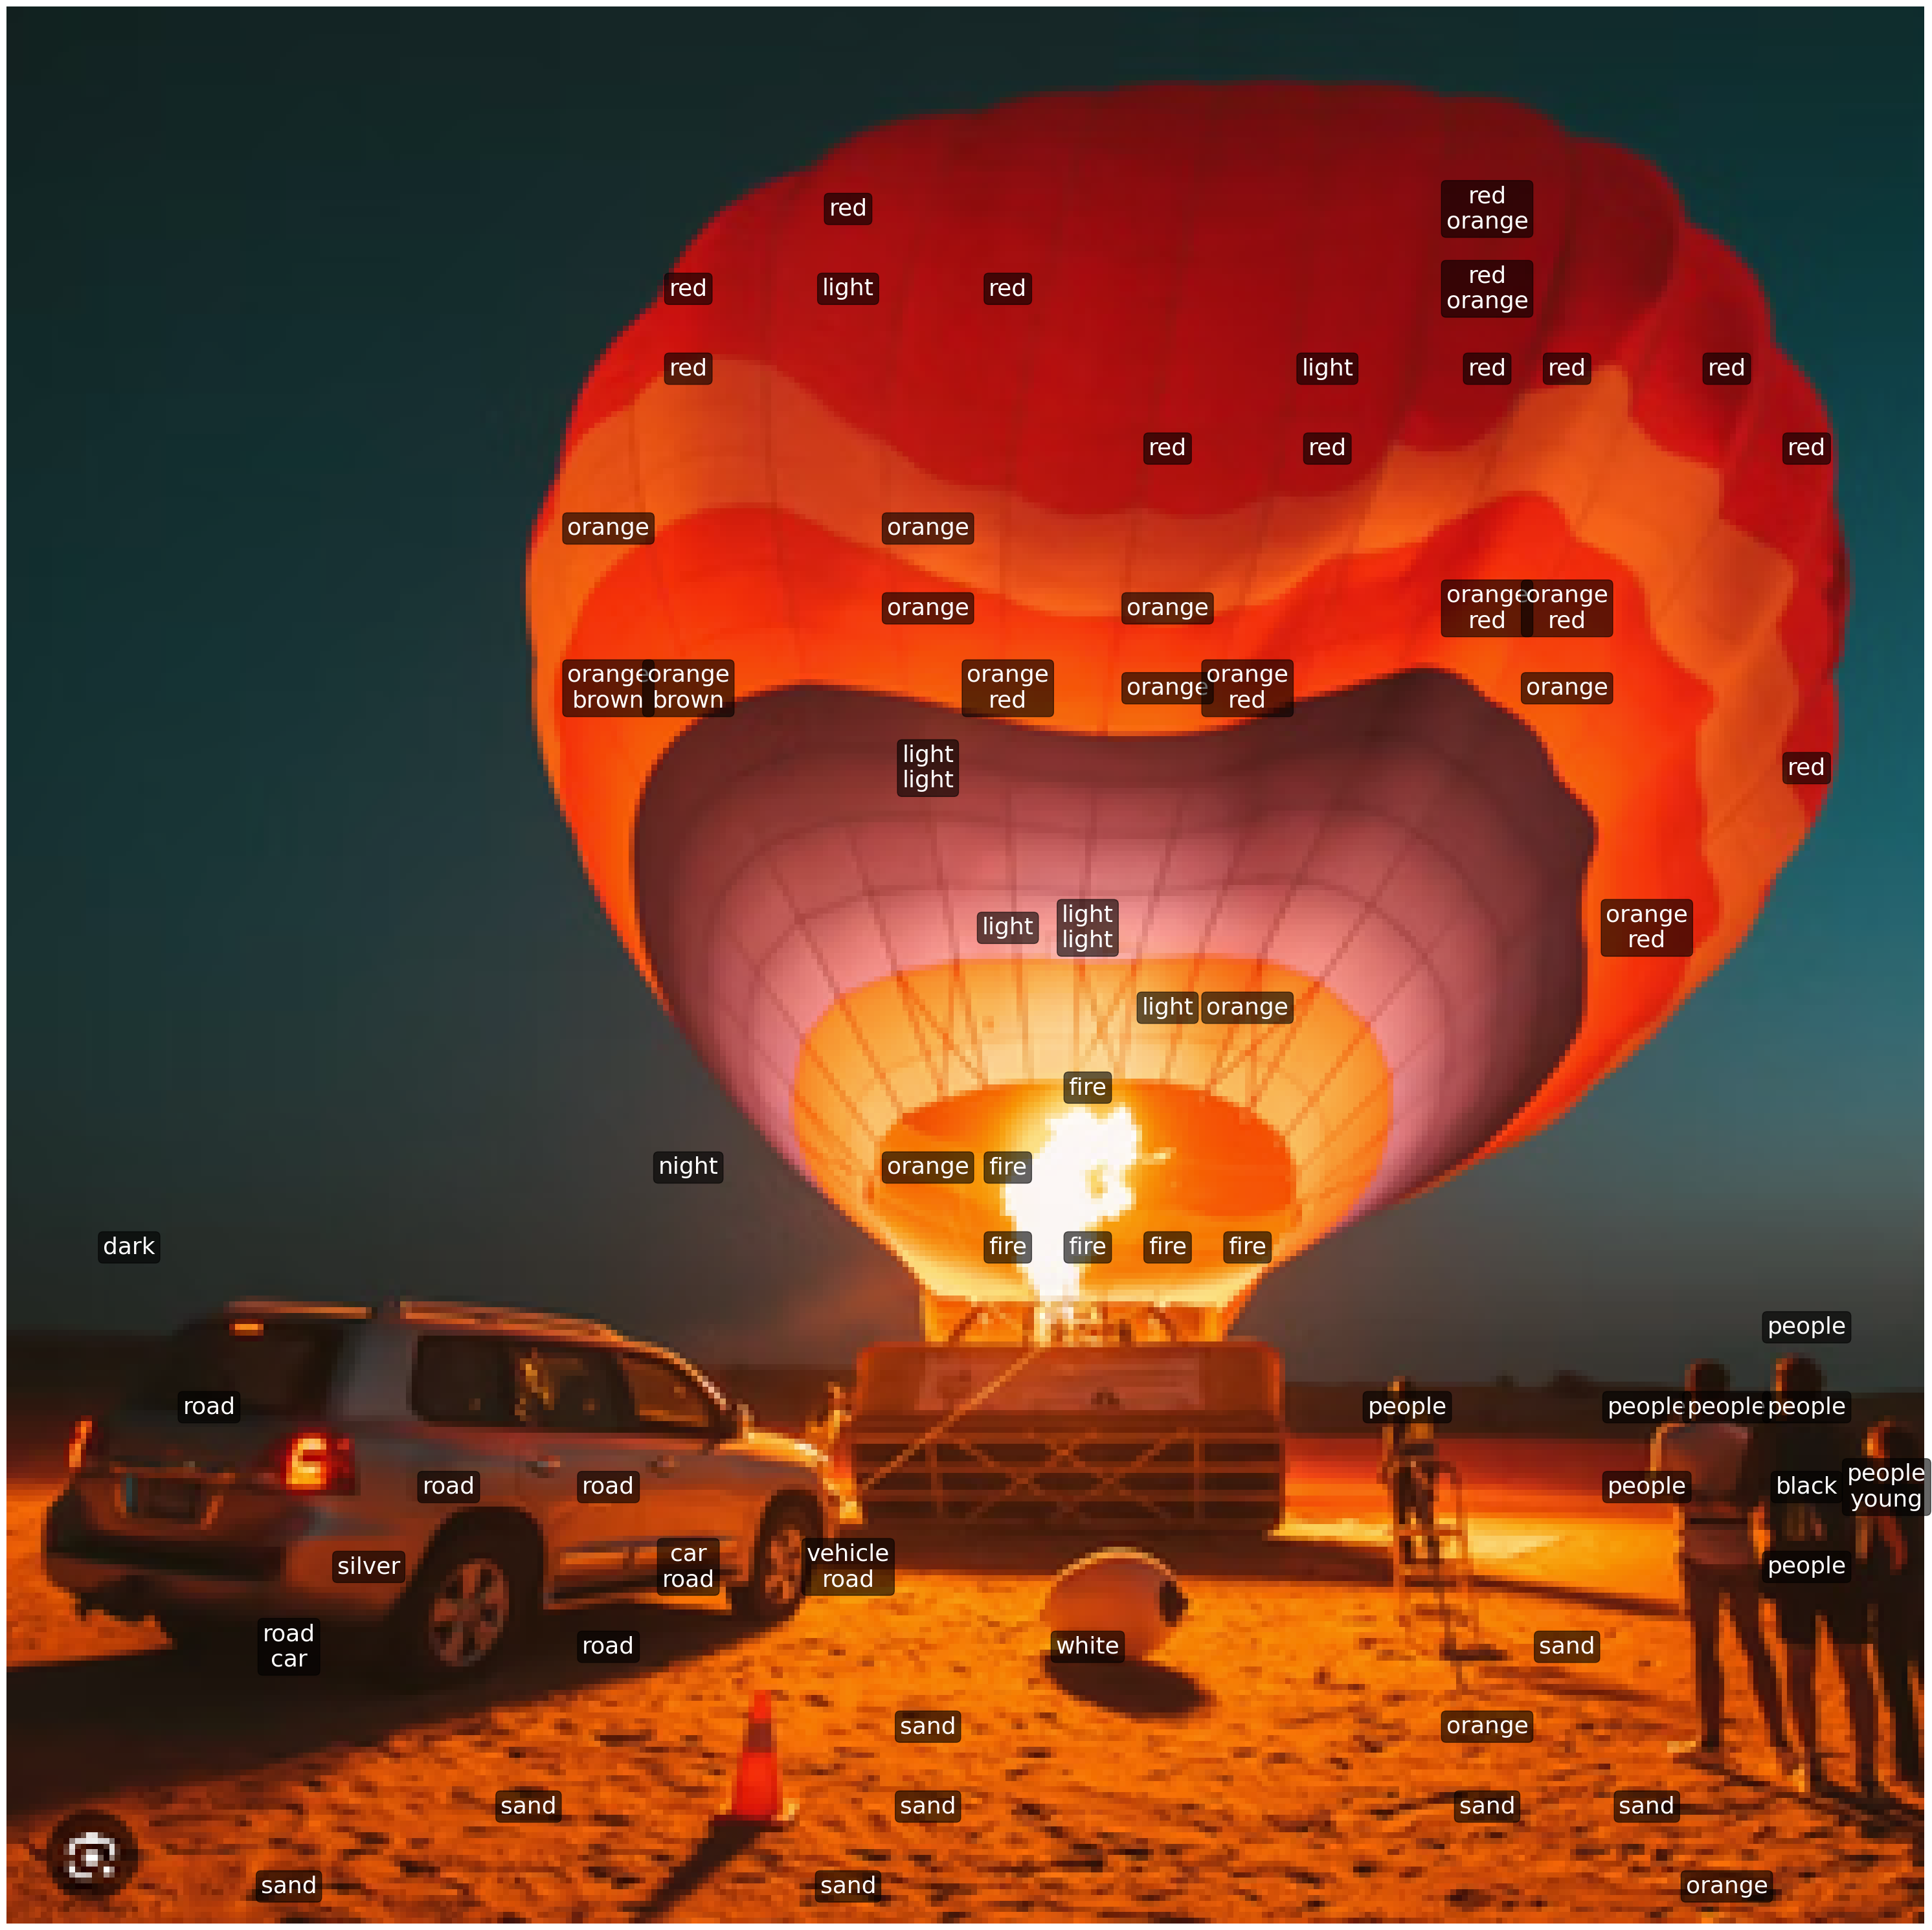

In [85]:
patch_size = vision_config.patch_size
image_size = vision_config.image_size
grid_size = image_size // patch_size

with torch.no_grad():
    visualize_top_k_tokens_on_patches(
        image, 
        token_embeddings,
        projected_features,
        tokenizer,
        patch_size=patch_size,
        grid_size=grid_size,
        top_k=5
    )

# Lora
## Trainable parameters

In [86]:
from peft import LoraConfig, get_peft_model, PeftModel

def find_all_linear_names(model):
    """
    Find all linear layer names in the model that are suitable for LoRA.
    Excludes multimodal components (vision tower, mm_projector, etc.)
    """
    cls = torch.nn.Linear
    lora_module_names = set()
    multimodal_keywords = ['mm_projector', 'vision_tower', 'vision_resampler']
    
    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in multimodal_keywords):
            continue
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    
    return list(lora_module_names)

def prepare_model_for_lora(
    model, 
    lora_r=64,            # LoRA rank - lower means fewer parameters, higher means more capacity
    lora_alpha=16,        # LoRA alpha - scaling factor (usually 2x to 4x of rank)
    lora_dropout=0.05,    # LoRA dropout - regularization to prevent overfitting
    bias="none",          # Whether to train bias parameters ("none", "all", or "lora_only")
    target_modules=None,  # Which modules to apply LoRA to. If None, will find all linear layers
    task_type="CAUSAL_LM" # Task type for LoRA configuration
):
    if target_modules is None:
        target_modules = find_all_linear_names(model)

    lora_config = LoraConfig(
        r=lora_r,
        lora_alpha=lora_alpha, 
        target_modules=target_modules,
        lora_dropout=lora_dropout, 
        bias=bias,
        task_type=task_type,
    )
    peft_model = get_peft_model(model, lora_config)
    
    return peft_model

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}%"
    )
    return trainable_params, all_param

import gc
import copy

# Store results for comparison
config_results = []

model_config1 = copy.deepcopy(model)
model_config1 = prepare_model_for_lora(model_config1, lora_r=64)
trainable1, total1 = print_trainable_parameters(model_config1)
del model_config1
config_results.append({"target_modules": "all", "rank": 64, "trainable": trainable1, "total": total1})

model_config1 = copy.deepcopy(model)
model_config1 = prepare_model_for_lora(model_config1, lora_r=32)
trainable1, total1 = print_trainable_parameters(model_config1)
del model_config1
config_results.append({"target_modules": "all", "rank": 32, "trainable": trainable1, "total": total1})

model_config2 = copy.deepcopy(model)
model_config2 = prepare_model_for_lora(model_config2, lora_r=16)
trainable2, total2 = print_trainable_parameters(model_config2)
del model_config2
config_results.append({"target_modules": "all", "rank": 16, "trainable": trainable2, "total": total2})

attention_modules = ["q_proj", "v_proj"]  # Only attention query and value projections ("attention blocks")
model_config3 = copy.deepcopy(model)
model_config3 = prepare_model_for_lora(model_config3, lora_r=64, target_modules=attention_modules)
trainable3, total3 = print_trainable_parameters(model_config3)
del model_config3
config_results.append({"target_modules": "attention only", "rank": 64, "trainable": trainable3, "total": total3})

model_config4 = copy.deepcopy(model)
model_config4 = prepare_model_for_lora(model_config4, lora_r=32, target_modules=attention_modules)
trainable4, total4 = print_trainable_parameters(model_config4)
del model_config4
config_results.append({"target_modules": "attention only", "rank": 32, "trainable": trainable4, "total": total4})

model_config4 = copy.deepcopy(model)
model_config4 = prepare_model_for_lora(model_config4, lora_r=16, target_modules=attention_modules)
trainable4, total4 = print_trainable_parameters(model_config4)
del model_config4
config_results.append({"target_modules": "attention only", "rank": 16, "trainable": trainable4, "total": total4})

trainable params: 169345024 || all params: 7232247808 || trainable%: 2.34%
trainable params: 84672512 || all params: 7147575296 || trainable%: 1.18%
trainable params: 42336256 || all params: 7105239040 || trainable%: 0.60%
trainable params: 39845888 || all params: 7102748672 || trainable%: 0.56%
trainable params: 19922944 || all params: 7082825728 || trainable%: 0.28%
trainable params: 9961472 || all params: 7072864256 || trainable%: 0.14%


In [91]:
# Print comparison table
print("## Configuration Comparison ##")
print("----------------------------------------")
print(f"{'Target modules':<25} {'rank':<6}  {'Trainable':<12} {'% of Model':<12}")
print("----------------------------------------")
for config in config_results:
    print(f"{config['target_modules']:<25}{config['rank']:<6} {config['trainable']:<12,d} {(config['trainable']/config['total']*100):.4f}%")

## Configuration Comparison ##
----------------------------------------
Target modules            rank    Trainable    % of Model  
----------------------------------------
all                      64     169,345,024  2.3415%
all                      32     84,672,512   1.1846%
all                      16     42,336,256   0.5958%
attention only           64     39,845,888   0.5610%
attention only           32     19,922,944   0.2813%
attention only           16     9,961,472    0.1408%


## Model structure

# Examples

## Dataset example

## Model output example

### Load our finetuned model

### Create outputs with original and finetuned model